In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


# Nicholson's blowfly model

\begin{align*}
    y_t &\sim \text{Poisson}(\phi N_t) \\
    S_t &\sim \text{Binom}\left( N_{t-1}, \exp{\left(-\delta \epsilon_t\right)} \right), \qquad t = 1, \dots, T\\
    R_t &\sim \text{Poisson}\left(P N_{t-\tau-1} \exp{\left( - \frac{N_{t-\tau-1}}{N_0}\right)} e_t \right), \qquad t = \tau +1, \dots, T\\
    \epsilon_t &\sim \Gamma(\beta_\epsilon, \beta_\epsilon),  \qquad t = 1, \dots, T\\
    e_t &\sim \Gamma(\beta_e, \beta_e),  \qquad t = \tau +1, \dots, T
\end{align*}
where $N_t = S_t + R_t$ for $t = \tau + 1, \dots, T$, $N_t = S_t$ for $t = 1, \dots, \tau$ and $N_0 = 50$, with model parameters  $$\mathbf{\theta} = (\delta, P, \beta_\epsilon, \beta_e, \phi)$$.

### 1.1. Simulator

In [2]:
# simulator
def blowfly(theta: torch.Tensor, N0=50, tau=5, T=100) -> torch.Tensor:
    '''
    Simulate the Nicholson's blowfly model
    '''

    # sample environmental noise terms
    epsilon = D.Gamma(theta[...,2], theta[...,2]).sample((T+1,)).T
    e = D.Gamma(theta[...,3], theta[...,3]).sample((T + 1,)).T
    
    # simulate hidden state
    N = torch.zeros_like(epsilon)
    N[...,0] = N0
    
    for t in range(1, T+1):
        if t <= tau:
            N[...,t] = D.Binomial(N[...,t-1], torch.exp(-theta[...,0] * epsilon[...,t])).sample()
        else:
            St = D.Binomial(N[...,t-1], torch.exp(-theta[...,0] * epsilon[...,t])).sample()

            lambdar = theta[...,1] * N[...,(t - tau - 1)] * torch.exp(-N[...,(t - tau - 1)] / N0) * e[...,t]
            Rt = D.Poisson(lambdar).sample()
            
            N[...,t] = St + Rt

    
    # # sample observables
    y = D.Poisson(theta[...,-1].unsqueeze(1) * N).sample()

    return y

In [107]:
(y[:,1:] - y[:,:-1]).shape

torch.Size([2, 400])

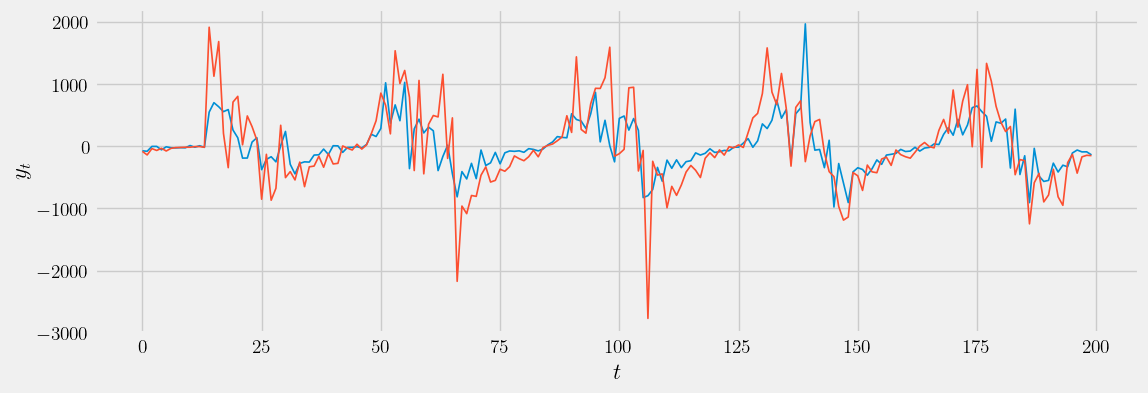

In [155]:
# model 1
theta = torch.tensor([[0.16, 6.5, 10, 10, 1],[0.16, 6.5, 10, 10, 1.8]])
T = 200
N0 = 400
tau = 14

y = blowfly(theta, N0, tau, T)

plt.figure(figsize=(12,4))
plt.plot(torch.arange(T), (y[:,1:] - y[:,:-1]).T, lw=1.2)

plt.xlabel(r'$t$')
plt.ylabel(r'$y_t$')
plt.show()


### 1.2. Prior

Using the following prior from *Llewellyn, Mary, Ruth King, Víctor Elvira, and Gordon Ross. "A point mass proposal method for Bayesian state-space model fitting." Statistics and Computing 33, no. 5 (2023): 111.*

\begin{align*}
    \delta &\sim \Gamma(0.007, 0.01) \\
    P &\sim \Gamma(50, 1)\\
    \beta_\epsilon &\sim \Gamma^{-1}(100, 100)\\
    \beta_e &\sim \Gamma^{-1}(10, 1)\\
    \phi &\sim \Gamma(0.01, 0.01)
\end{align*}

In [4]:
class GammaInverseGamma():
    def __init__(self, params_delta, params_p,  params_beta_eps, params_beta_e, params_phi):
        # recode hyperparameter values
        self.params = {'delta':params_delta, 'P':params_p, 'beta_eps':params_beta_eps, 
                       'beta_e':params_beta_e, 'phi': params_phi}
        
        # define marginal distributions
        self.delta = D.Gamma(self.params['delta']['alpha'], self.params['delta']['beta'])

        self.P = D.Gamma(self.params['P']['alpha'], self.params['P']['beta'])
        
        self.beta_eps = D.InverseGamma(self.params['beta_eps']['alpha'],  self.params['beta_eps']['beta'])
        
        self.beta_e = D.InverseGamma(self.params['beta_e']['alpha'],  self.params['beta_e']['beta'])
        
        self.phi = D.Gamma(self.params['phi']['alpha'], self.params['phi']['beta'])

    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.delta.sample(shape),
                            self.P.sample(shape),
                            self.beta_eps.sample(shape),
                            self.beta_e.sample(shape),
                            self.phi.sample(shape)
                            ], dim=-1)
       
        
        return theta
        
    def log_prob(self, theta):
        logprob = self.delta.log_prob(theta[...,0]) + self.P.log_prob(theta[...,1]) +\
        self.beta_eps.log_prob(theta[...,2]) + self.beta_e.log_prob(theta[...,3]) + self.phi.log_prob(theta[...,4])

        return logprob


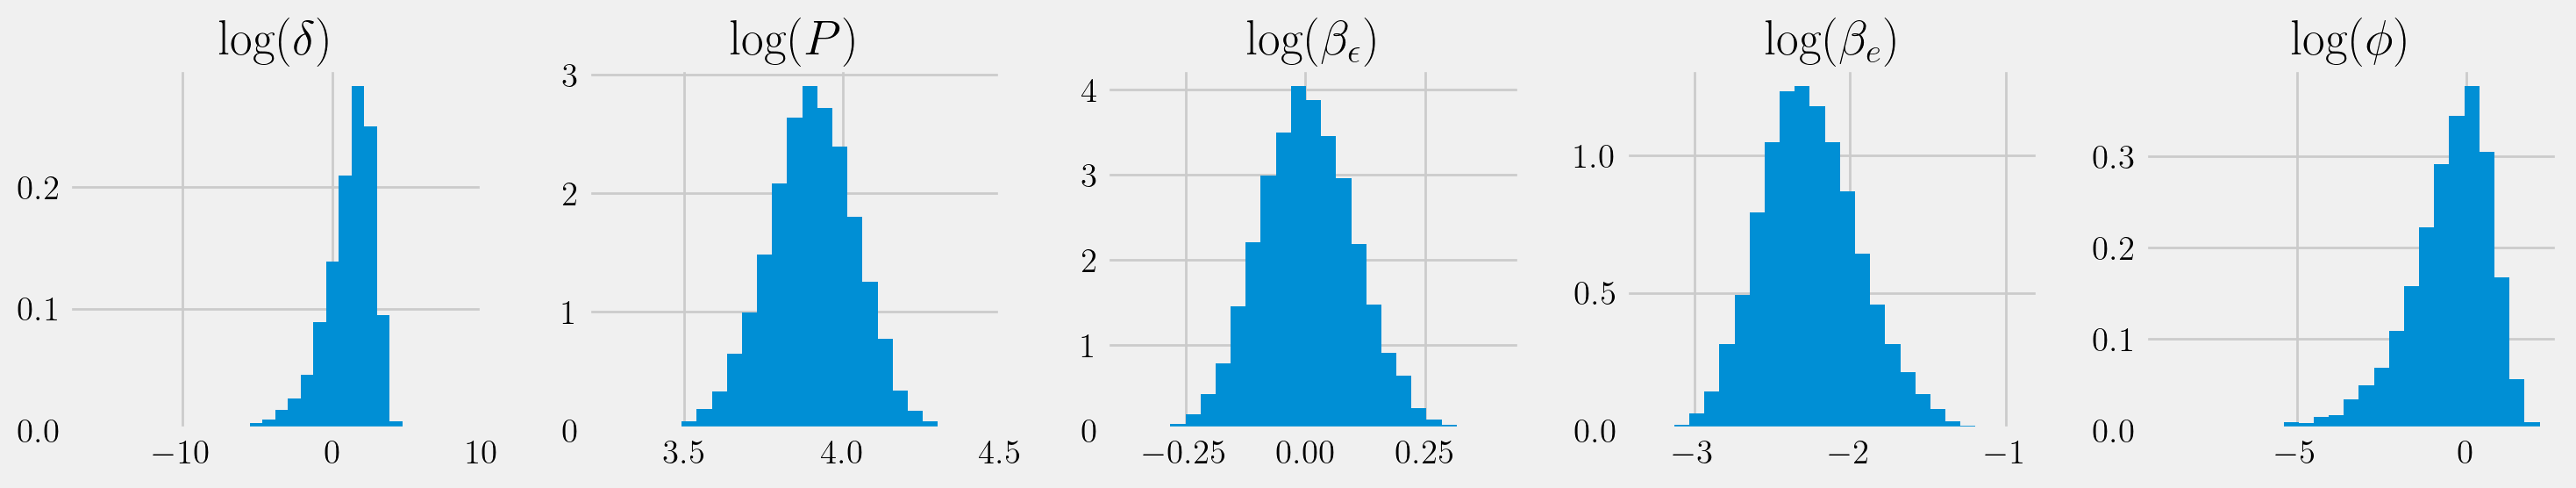

In [5]:
delta = {'alpha': 0.7, 'beta': .1}
P = {'alpha': 50.0, 'beta': 1.0}
beta_eps = {'alpha': 100.0, 'beta': 100.0}
beta_e = {'alpha': 10.0, 'beta': 1.0}
phi = {'alpha': 1.0, 'beta': 1.0}


prior = GammaInverseGamma(delta, P, beta_eps, beta_e, phi)

N = 10000
theta =  prior.sample((N,))

fig = plt.figure(figsize=(15, 3), dpi=200)

fig.add_subplot(151)

plt.hist(theta[...,0].log(), bins=25, density=True)
plt.xlim(right=10)
plt.title(r'$\log(\delta)$')

fig.add_subplot(152)
plt.hist(theta[...,1].log(), bins=25, density=True)
plt.title(r'$\log(P)$')

fig.add_subplot(153)
plt.hist(theta[...,2].log(), bins=25, density=True)
plt.title(r'$\log(\beta_\epsilon) $')

fig.add_subplot(154)
plt.hist(theta[...,3].log(), bins=25, density=True)
plt.title(r'$\log(\beta_e) $')

fig.add_subplot(155)
plt.hist(theta[...,4].log(), bins=25, density=True)
plt.title(r'$\log(\phi) $')

plt.tight_layout()
plt.show()

### 3. Neural Net

In [159]:
class Net(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 


        # convolutional layers
        self.conv = nn.Sequential(
            nn.Conv1d(1, 1, 5),
            nn.ELU(),
            nn.MaxPool1d(2),
            #nn.LayerNorm((self.input_size - 4) // 2),
            nn.Conv1d(1, 1, 5),
            nn.ELU(),
            nn.MaxPool1d(2)#,
            #nn.LayerNorm((((self.input_size - 4) // 2) - 4) // 2)
        )

        # fully connected (((self.input_size - 4) // 3) - 4) // 2layers
        self.fc = nn.Sequential(
            nn.Linear((((self.input_size - 4) // 2) - 4) // 2, self.hd),
            nn.ELU(),
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # apply convolutional layers
        x = self.conv(x)
        # flatten
        x = x.flatten(1)
        # apply fully-connected layers
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
     

class LSTMNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 

        # lstm layer
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hd, num_layers=2, batch_first=True)

        # fully connected hidden layer
        self.fc = nn.Sequential(
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # lstm & hidden layers
        x, _ = self.lstm(x)
        x = x[:,-1,:]   # extract final time step
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
    

### 4. Training

In [160]:
def transform_data(data, period_length):
    dataset = data.clone()
    #dataset[...,1:] = data[...,1:] - data[...,:-1]
    #dataset = (dataset - dataset.mean(dim=0).unsqueeze(1)) / dataset.std(dim=-1).unsqueeze(1)
    Y = []

    for i in range(dataset.size(1) // period_length):
        period = dataset[...,i*period_length:(i*period_length + period_length)]
        Y.append(period)
    
    return torch.stack(Y, dim=1)

Epoch 1 Loss 6.511022809743881 

Epoch 2 Loss 6.2434558057785035 

Epoch 3 Loss 6.0739521265029905 

Epoch 4 Loss 5.907520586252213 

Epoch 5 Loss 5.755779502391815 

Epoch 6 Loss 5.593178141117096 

Epoch 7 Loss 5.378710576295853 

Epoch 8 Loss 5.100171234607696 

Epoch 9 Loss 4.936032652854919 

Epoch 10 Loss 4.801599789857864 

Epoch 11 Loss 4.692671275138855 

Epoch 12 Loss 4.69301286637783 

Epoch 13 Loss 4.622948551774025 

Epoch 14 Loss 4.5946923828125 

Epoch 15 Loss 4.587041696906089 

Epoch 16 Loss 4.601461511850357 

Epoch 17 Loss 4.575085647702217 

Epoch 18 Loss 4.573451260328293 

Epoch 19 Loss 4.5531864416599275 

Epoch 20 Loss 4.534365000128746 

Epoch 21 Loss 4.538301087617874 

Epoch 22 Loss 4.5243911021947865 

Epoch 23 Loss 4.478357486724853 

Epoch 24 Loss 4.4399658268690105 

Epoch 25 Loss 4.422323279380798 

Epoch 26 Loss 4.472317678928375 

Epoch 27 Loss 4.481057542562485 

Epoch 28 Loss 4.477604623436928 



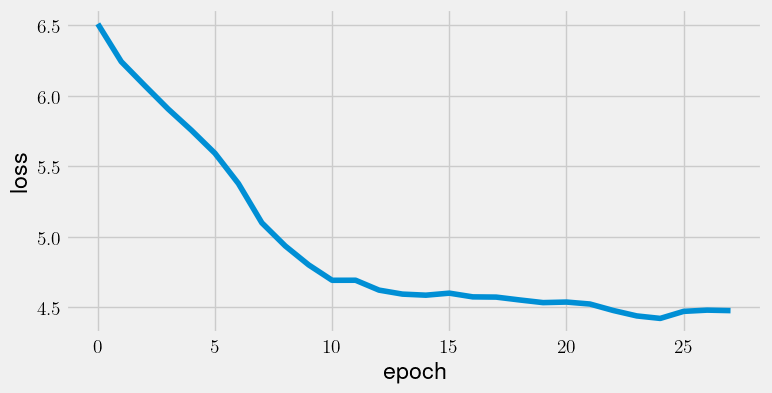

In [161]:
#Explicitly provided seeds for training process
random_seed = 12345
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, n_sample, period_length,  batchsize = 10000, 600, 1, 10, 25

# sample parameter values from the specified prior
Theta_train =  prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
Y_train = blowfly(Theta_train, N0=50, T=n_obs)
Y_train = transform_data(Y_train, period_length=period_length)

# put sigma and rho on log-scale for improved training
Theta_train = Theta_train.log()

# standardize alpha
mean_param, std_param =  Theta_train.mean(dim=0), Theta_train.std(dim=0)
Theta_train = (Theta_train - mean_param) / std_param

# create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train, Theta_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)


#==================================================
#  instantiate the Gaussian mixture net
#=================================================
gmmnet = LSTMNet(input_size=period_length, dim=5, K=1, hd=64).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=2e-3,
                       eps=0.001, 
                       max_epochs=200,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/gmrf1d/gp_rho_sigma_1.pt'
                      )

#gmmnet = torch.load('trained_models/gmrf1d/gp_rho_sigma_3.pt')

### Posterior vs prior distributions

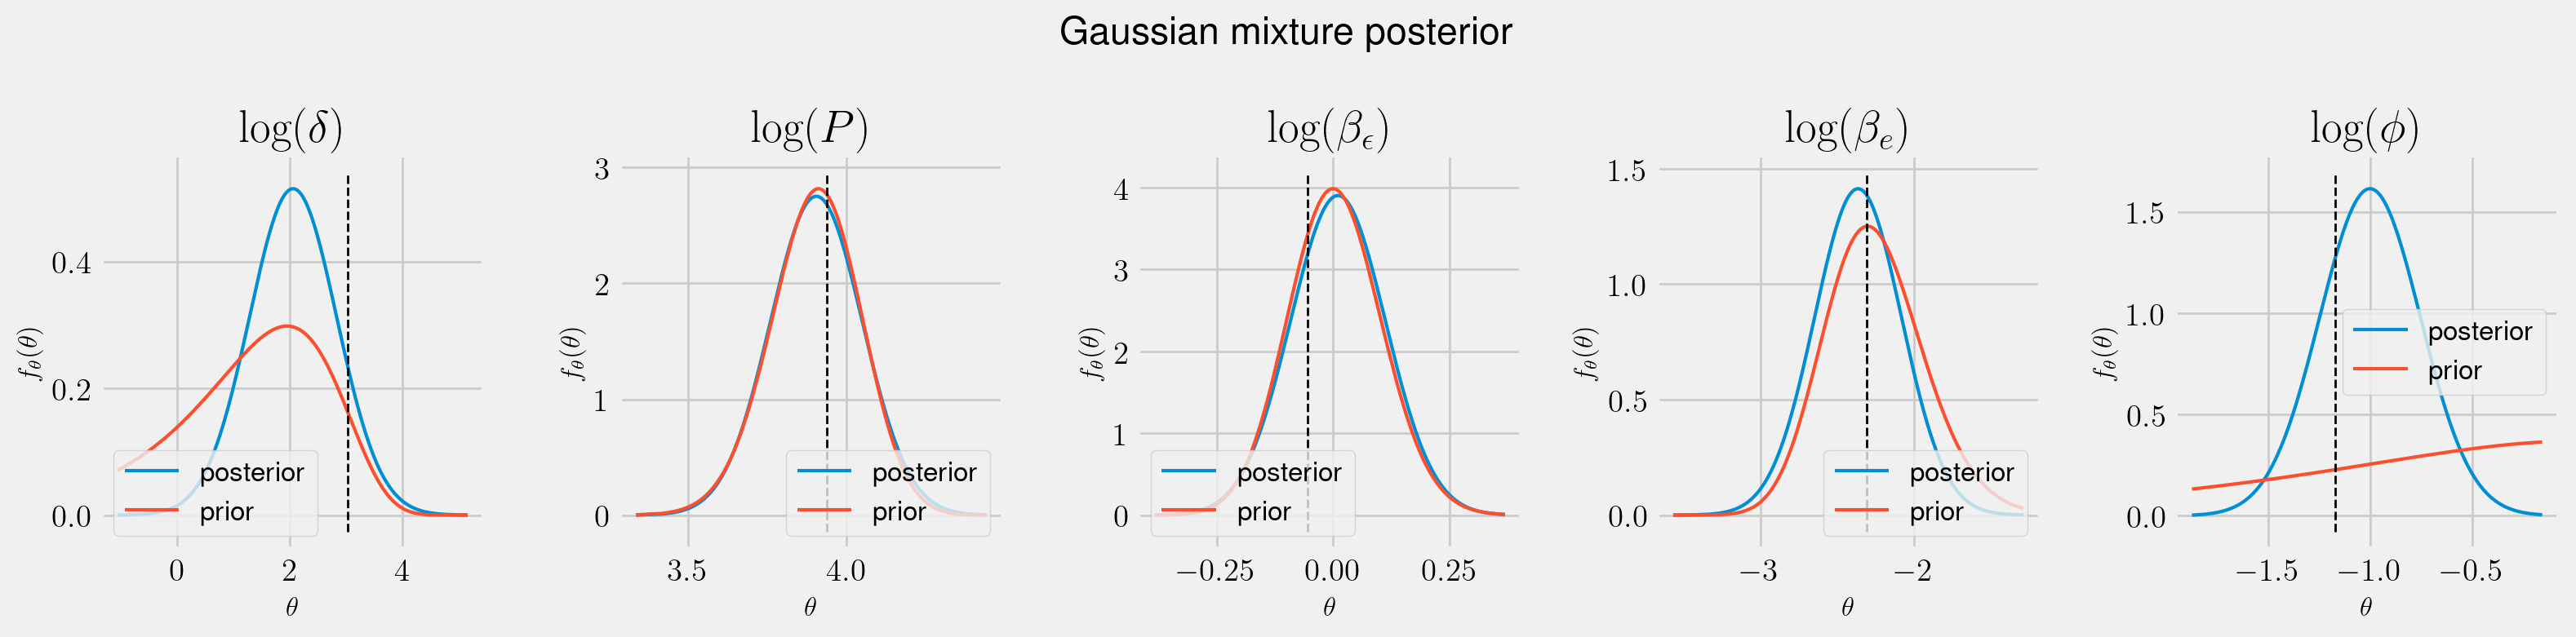

In [158]:
# model 1
theta = prior.sample().unsqueeze(0)

y = blowfly(theta, N0=50, T=n_obs)
y = transform_data(y, period_length)

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)


# plotting
fig = plt.figure(figsize=(16, 4), dpi=200)

labels = [r'$\log(\delta)$', r'$\log(P)$',  r'$\log(\beta_{\epsilon}) $', r'$\log(\beta_e) $', r'$\log(\phi) $']

for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,k].squeeze(), torch.sqrt(covariance[:,:,k,k]).squeeze())

    # draw samples from the approximate posterior
    N = 10000
    theta_k_scaled = gmm.sample((N,)).squeeze().sort().values 
    theta_k = theta_k_scaled * std_param[k] + mean_param[k]
    pdf = gmm.log_prob(theta_k_scaled).exp().cpu() / std_param[k] 
    theta_k = theta_k.cpu()

    
    # prior
    theta_inv = theta_k.exp()
    if k == 0:
        pdf_prior = prior.delta.log_prob(theta_inv).exp() * abs(theta_inv)
    elif k == 1:
        pdf_prior = prior.P.log_prob(theta_inv).exp() * abs(theta_inv)
    elif k == 2:
        pdf_prior = prior.beta_eps.log_prob(theta_inv).exp() * abs(theta_inv)
    elif k == 3:
        pdf_prior = prior.beta_e.log_prob(theta_inv).exp() * abs(theta_inv)
    else:
        pdf_prior = prior.phi.log_prob(theta_inv).exp() * abs(theta_inv)
    
    # true value    
    theta_k_true =  theta[:,k].log()
    
    fig.add_subplot(1, dim, k+1)
    
    plt.plot(theta_k, pdf, lw=1.5, label='posterior')
    plt.plot(theta_k, pdf_prior, lw=1.5, label='prior')
    plt.vlines(x=theta_k_true, ymin=plt.axis()[2], ymax=plt.axis()[3], linestyles='dashed', colors='black', lw=1)
    
    plt.xlabel(r'$\theta$', fontsize=12)
    plt.ylabel(r'$f_\theta(\theta)$', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(labels[k])

plt.suptitle('Gaussian mixture posterior')
plt.tight_layout()
plt.show()

### Simulation-based calibration check

In [250]:
def sbc_gaussian(gmmnet, proposal, n_sim = 1e+4, ecdf=True, ecdf_diff=False, logscale=None, labels=None):
    '''
    Perform simulation-based calibration check for a Gaussian mixture network for posterior approximation

    Input:
        -- gmmnet: Gaussian mixture network, with input size given by `sample_size`
        -- proposal: proposal distribution `theta ~ p(theta)`, usually the same as the prior/proposal distribution used for training
                     Note: must have a `sample()` method
        
        -- generator: function that takes parameter values `theta` as input and generate the corresponding simulator model
                       `x ~ p(x|theta)`  as an instance of a class with a `sample` method
        
        -- sample_size: number of iid samples from `x ~ p(x|theta)` for each values of theta

        -- n_sim: number of simulation from the joint distribution: theta ~ p(theta); x ~ p(x|theta)

        -- ecdf: whether to output an eCDF or a histogram plot, default: ecdf=True

        -- ecdf_diff: whether on the y-axis are the `ecdf(w)` values (if True) or `ecdf(w) - w` values (if False).
                        This is ignored if ecdf=False.
        
        -- logscale: (iterable) contains dimensions of the model parameter vector `theta` that are on log-scale
                        note: we use the standard Python counting, starting at 0

    Note: 95% confidence intervals are based on the  Dvoretzky–Kiefer–Wolfowitz inequality (see https://en.wikipedia.org/wiki/Empirical_distribution_function, accessed: 20-05-2024)
    
    Output: SBC plot as a Pyplot figure
    '''

    # draw samples from the prior/proposal  theta ~ p(theta)
    Theta = proposal.sample((n_sim,))

    # draw samples from the model x ~ p(x|theta)
    X = blowfly(Theta, N0=50, T=n_obs).unsqueeze(1)

    #Theta = Theta[:,1:3]
    
    # ensure all dimensions are on the right scale
    if logscale:
        for i in logscale:
            Theta[:,i] = Theta[:,i].log()     # put sigma2 on logscale

    
    # run the gmmnet
    with torch.no_grad():
        mean, chol, coeff = gmmnet(X.to(device))

    n_component, dim = mean.shape[1], mean.shape[2]

    # calculate Cholesky factors
    chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

    # caclulate precision matrices
    precision = chol @ chol.transpose(2, 3)

    # calculate covariance matrices
    covariance = torch.linalg.inv(precision) 

    # define GMM variational marginal distributions and calculate cdf values for the true parameter values
    W = torch.zeros((n_sim, dim))   # tensor of cdf values
    
    for j in range(dim):
        # mixture weights
        mix = D.Categorical(coeff)
        # mixture components
        comp = D.Normal(mean[:,:,j], torch.sqrt(covariance[:,:,j,j]))
        # define the mixture
        gmm = D.MixtureSameFamily(mix, comp)
        # evaluate cdf
        W[:,j] = gmm.cdf(Theta[:,j].to(device))


    if ecdf:
        #=====================================================
        # ECDF plot
        #=====================================================
        fig = plt.figure(figsize=(16, 3), dpi=200)

        # Calculate the empirical cumulative distribution function (ECDF)
        eCDF = torch.arange(1, n_sim + 1) / n_sim

        # calculate 95% confidence intervals for the eCDF
        eps = np.sqrt(np.log(2 / 0.05) / (2 * n_sim))
        eCDF_lower, eCDF_upper = eCDF - eps, eCDF + eps

        # exact cdf
        x = np.linspace(0, 1, 100)

        # eCDF for p
        #===============
        for j in range(dim):
            fig.add_subplot(1,dim,j+1)

            w = W[:,j].sort().values
            if not ecdf_diff:
                # plot eCDF and true CDF values
                plt.step(w, eCDF, lw=1)
                plt.plot(x, x, 'k--', lw=1)

                # plot 95% confidence bands
                plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)

                plt.ylabel(r'$F_{\omega}$')
            else:
                plt.step(w, eCDF - w, lw=1)
                #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
                plt.ylabel(r'$F_{\omega} - \omega$')

            plt.xlabel(r'$\omega$')
            plt.title(labels[j])

        plt.tight_layout()

    else:
        #========================================
        # plot histograms
        #========================================
        fig = plt.figure(figsize=(16, 3), dpi=200)

        for j in range(dim):
            fig.add_subplot(1,dim,j+1)
            plt.hist(W[:,j], bins=25, density=True, alpha=.6)
            plt.title(labels[j])

        plt.tight_layout()    

    return fig

In [251]:
f = sbc_gaussian(gmmnet, prior, 10000, ecdf=True, ecdf_diff=False, logscale=[0,1,2,3,4], labels=labels)

_LinAlgError: linalg.inv: (Batch element 11791): The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

In [271]:
from pyvi.utils.GMMLossFunc import to_triangular, exp_diagonal, GaussianLoss

class GaussianMixtureLoss(nn.Module):
    '''
            Evaluate the negative log-likelihood loss (NLL) function for a Gaussian mixture model/network.

            Input
            =====
                -- target (Tensor): contains the ``evaluation`` examples where the loss has to be evaluated 

                -- mean (Tensor):  contains the mean of each component of the Gaussian mixture model for each evaluation example
                
                -- precision_cholesky (Tensor): contains the off-diagonal elements and log-scaled diagonal elements of the 
                                                Cholesky factor of the precision matrix of each component of the Gaussian mixture
                                                model for each evaluation example
                -- coeff (Tensor): contains the mixture coefficients for each evaluation example by row

            
            Output
            ======
            Gaussian mixture NLL aggregated across evaluation examples

            .
            
        '''

    def __init__(self, aggr=None):
        '''
        `aggr` specifies what aggregation measure to apply when evaluating the loss on more than one example at once. Possible values are 
            -- aggr = None ---> no aggregation
            -- aggr = "mean" ---> return the mean loss
            -- aggr = "sum"  ---> return the sum of losses
        '''
        super().__init__()
        self.aggr = aggr
    
    def forward(self,
       target : torch.Tensor,
       mean: torch.Tensor,
       precision_cholesky: torch.Tensor,
       coeff: torch.Tensor=torch.ones(1)
       ) -> torch.Tensor:    
        
       N = target.shape[0]            # number of training examples
       dim = target.shape[-1]         # dimension of the posterior distribution
       K = coeff.shape[-1]            # number of components

       # if the number of components K = 1
       if K==1:
              loss = GaussianLoss(target, mean, precision_cholesky, self.aggr)

       # if the number of components K > 1
       else:
              #-------------------------------------------------------------------------------------------------------------------------
              # 1) Calculate G_1 ~ (N, K) tensor where G_1^(i, k) is the loss from kth component evaluated at the ith training example  #
              #-------------------------------------------------------------------------------------------------------------------------

              # 1.1. replicate target tensor by number of components
              target = target.repeat_interleave(repeats=K, dim=0)     

              # 1.2. reshape mean & precision_cholesky tensors so we can evaluate losses for all components at once                           
              mean = mean.reshape((K * N, dim))        
              precision_cholesky = precision_cholesky.reshape((K * N, precision_cholesky.shape[-1])) 

              # 1.3. evaluate losses by component and training example
              losses = GaussianLoss(target, mean, precision_cholesky, aggr=None).reshape((N, K))
              #print(losses.shape)
              #---------------------------------------------------------------------------------------------------------------------
              # 2) calculate G_2 =  - G_1 * log(A) where A is the matrix of mixing coefficients and '*' is the element-wise multiplication
              #---------------------------------------------------------------------------------------------------------------------
              losses = - losses * coeff.log().to(dtype=losses.dtype)
              #losses = torch.bmm(losses.view(N, 1, K), coeff.view(N, K, 1).to(dtype=losses.dtype)).squeeze().to(dtype=torch.float64)
              #print(losses.shape)
              #----------------------------------------------------------------------------------------------------------------------
              # 3)     calculate G_3 = log(sum(exp(G_2))) where the sum is over the components of the mixture  in a robust approach     #
              #---------------------------------------------------------------------------------------------------------------------
              maxlosses, idx = losses.max(dim=1)
              # non-max indices
              mask = torch.ones_like(losses)
              mask.scatter_(dim=1, index=idx.unsqueeze(1), value=0)

              losses = (losses - maxlosses.unsqueeze(1)).exp() 
              
              # sum non-max values
              p = losses[mask != 0].reshape(losses.size(0), losses.size(1)-1).sum(dim=1)

              # calulcate log(sum(losses)) as log(1 + p) & add maxlosses back
              losses = torch.log1p(p) + maxlosses
              
              
              #--------------------------------------------------------------------------------
              # 4)            calculate G_4 = - G_3 and loss J_phi = G_4.aggregate()             #
              #--------------------------------------------------------------------------------
              losses = - losses
              
              # aggregate over training examples
              if self.aggr == 'sum':
                     loss =  losses.sum()
              elif self.aggr == 'mean':
                     loss =  losses.mean()
              else:
                    loss = losses
        
       return loss


In [310]:
import numpy as np
idx = np.random.randint(0, Y_train.size(0), 20)
x_batch, y_batch = Y_train[idx,:].to(device), Theta_train[idx,:].to(device)

mean, chol, coeff = gmmnet(x_batch.unsqueeze(1))

loss_fn = GaussianMixtureLoss(aggr='mean')
loss_fn2 = lf.GaussianMixtureLoss(aggr='mean')

loss1 = loss_fn(y_batch, mean, chol, coeff)
loss2 = loss_fn2(y_batch, mean, chol, coeff)


In [293]:
x_batch.var(dim=1)[19]

tensor(1.3087e+08, device='cuda:0')

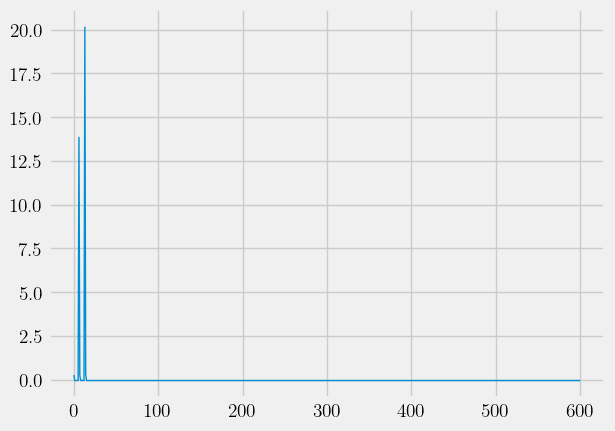

In [318]:
y = x_batch[19].cpu()

plt.plot((y - y.mean()) / y.std(), lw=1);
